<a href="https://colab.research.google.com/github/siddhusalvi/Covid-Data-Visualization/blob/AgeDistribution/Covid_Data_Visualisation_using_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-2.3.1/spark-2.3.1-bin-hadoop2.7.tgz
!tar xf spark-2.3.1-bin-hadoop2.7.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.3.1-bin-hadoop2.7"
import findspark
findspark.init()
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate() 
spark

Mounting Google Drive

In [ ]:
!pip install plotly==4.7.1
!wget https://github.com/plotly/orca/releases/download/v1.2.1/orca-1.2.1-x86_64.AppImage -O /usr/local/bin/orca
!chmod +x /usr/local/bin/orca
!apt-get install xvfb libgtk2.0-0 libgconf-2-4
import plotly.graph_objects as go

In [4]:
path = '/content/drive/My Drive/Siddhu/data/covidData.json'

In [7]:
from pyspark.sql.types import ArrayType, StructField, StructType, StringType, IntegerType,DateType
from pyspark.sql.functions import col,when

In [8]:
schema = StructType([
          StructField("agebracket", StringType(), True),
          StructField("backupnotes", StringType(), True),
          StructField("contractedfromwhichpatientsuspected", StringType(), True),
          StructField("currentstatus", StringType(), True),
          StructField("dateannounced", DateType(), True),
          StructField("detectedcity", StringType(), True),
          StructField("detecteddistrict", StringType(), True),
          StructField("detectedstate", StringType(), True),
          StructField("estimatedonsetdate", StringType(), True),
          StructField("gender", StringType(), True),
          StructField("nationality", StringType(), True),
          StructField("notes", StringType(), True),
          StructField("numcases", StringType(), True),
          StructField("patientnumber", StringType(), True),
          StructField("source1", StringType(), True),
          StructField("source2", StringType(), True),
          StructField("source3", StringType(), True),
          StructField("statecode", StringType(), True),
          StructField("statepatientnumber", StringType(), True),
          StructField("statuschangedate", DateType(), True),
          StructField("typeoftransmission", StringType(), True)
])

In [9]:
covidDF = spark.read.option("dateFormat", "dd/MM/yyyy").json(path, schema)

In [10]:
covidDF.count()

28183

In [ ]:
covidDF.show(100)

In [ ]:
covidDF.printSchema

# Age Group Visualization


In [42]:
ageGroupDF = covidDF.withColumn("age",col("agebracket").cast("Integer"))\
.withColumn("agegroup",when(col("age") < 15,"Minor").when(col("age")< 30,"Young").when(col("age")< 51,"Adult").when(col("age")> 50,"Older"))\
.filter(col('agegroup') != "null" )\
.groupby('agegroup').count()

ageGroupDF.show()

+--------+-----+
|agegroup|count|
+--------+-----+
|   Older|  584|
|   Minor|  161|
|   Adult|  980|
|   Young|  617|
+--------+-----+



In [49]:
ageGroupPDF = ageGroupDF.toPandas()

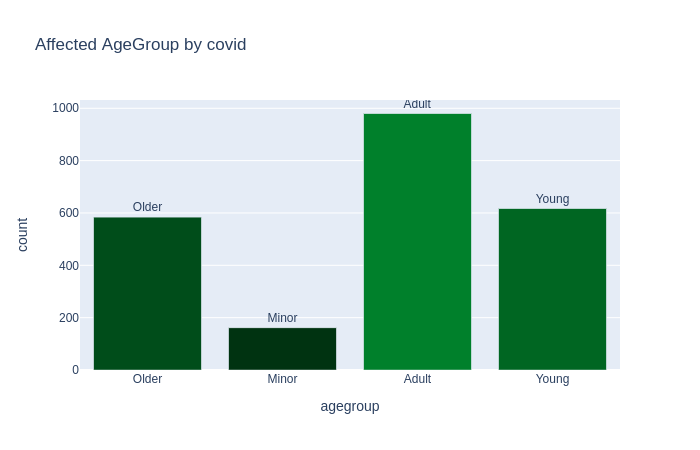

In [76]:
colors = ['#004d1a','#003311','#00802b','#006622']
import plotly.express as px
fig = px.bar(ageGroupPDF,x='agegroup', y='count',title="Affected AgeGroup by covid",text='agegroup')
fig.update_traces(textposition='outside',marker_color=colors)
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')
fig.show('png')

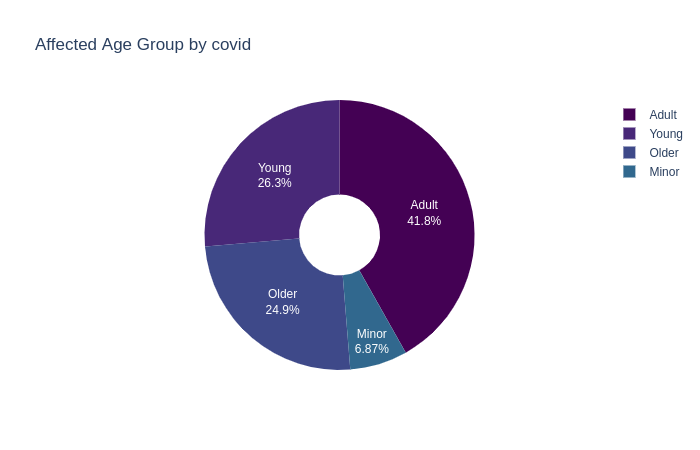

In [72]:
fig = px.pie(ageGroupPDF, values='count', names="agegroup", title="Affected Age Group by covid",color_discrete_sequence=px.colors.sequential.Viridis,hole=.3)
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show('png')

In [80]:
decesedAgeGroupDF = covidDF.withColumn("age",col("agebracket").cast("Integer"))\
.withColumn("agegroup",when(col("age") < 15,"Minor").when(col("age")< 30,"Young").when(col("age")< 51,"Adult").when(col("age")> 50,"Older"))\
.filter(col('agegroup') != "null" )\
.filter(col('currentstatus')=='Deceased')\
.groupby('agegroup').count()

decesedAgeGroupDF.show()

+--------+-----+
|agegroup|count|
+--------+-----+
|   Older|   32|
|   Minor|    1|
|   Adult|   10|
|   Young|    1|
+--------+-----+



In [83]:
decesedAgeGroupPDF = decesedAgeGroupDF.toPandas()

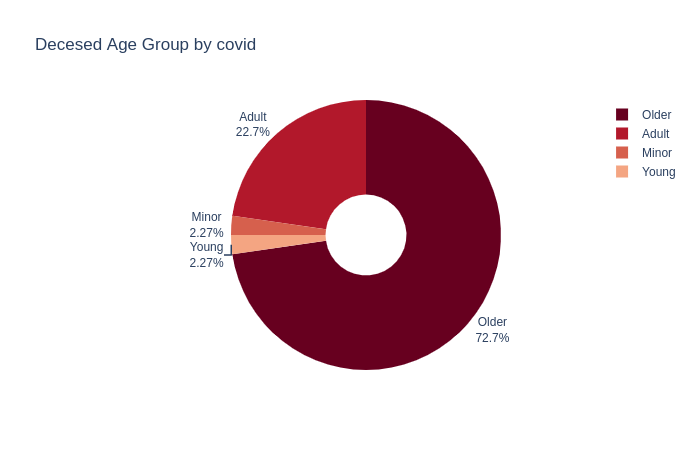

In [90]:
fig = px.pie(decesedAgeGroupPDF, values='count', names="agegroup", title="Decesed Age Group by covid",color_discrete_sequence=px.colors.sequential.RdBu,hole=.3)
fig.update_traces(textposition='outside', textinfo='percent+label')
fig.update_layout(uniformtext_minsize=12, uniformtext_mode='hide')
fig.show('png')